<a href="https://colab.research.google.com/github/microprediction/microprediction/blob/master/Election_in_the_run_with_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greetings! 

You might be here because you think


*   Betting markets are far more efficient then Nate Silver or G. Elliott Morris. I really can't help you if you insist otherwise - perhaps G. Elliott will offer you 19/1 on Trump LOL.  
*   Betting markets still requires some interpretation, because many punters are so lazy they don't even run simulations, or because they involve heterogeneous groups and some markets are products of others, approximately, so we get a convexity effect.  

See this post https://www.linkedin.com/posts/petercotton_is-bidens-chance-of-winning-90-percent-or-activity-6730191890530095104-njhk and if you like it, please react on linked-in so the marketting dollar for the open source prediction network goes further. Because it really is a dollar. 

## Okay then...

This notebook provides you with a simple interpretation of market implied state electoral college probabilities, nothing more. It can be used to compute things like the market implied correlation between states, using a very simple correlation model. That may, or may not, provide you with a new perspective on the markets or a lens as to their degree of internal consistency.

In using this, rather than the groovy graphics at 538, you are taking a stand against the ridiculous celebritization of statistics and journalistic group-think. 




In [46]:
import numpy as np
from pprint import pprint
import math
from scipy.stats import norm
   

# Current prices for Biden, expressed as inverse probabilities, and electoral votes
states = [ ('arizona',1.23,11), ('michigan',1.01,16), ('pennsylvania',1.03,20),
          ('georgia',1.12,16),('nevada',1.07,6),  ('north carolina',6.5,15), ('alaska',15,3),
          ('wisconsin',1.03,10)]

# Maybe you want to add Wisconsin. 
# Okay, let's see if this foreignor can get the basic electoral calculus right. 
# You might want to re-introduce some other states, but if so change the existing totals below: 
biden = 227
trump = 214   # Does not include Alaska


# Sanity check. 
undecided = sum([a[2] for a in states])
print(undecided)
total = biden + trump + undecided 
assert total==538



97


In [47]:
# Next ... let's write a little guy that simulated from modified state probabilities. Just ignore this if you
# don't think there is any correlation between results at this late stage of the race. 

# Perhaps, however, there is some latent correlation still in the results - related to legal moves or military voting patterns or
# consistent bias across state markets. I will merely remark that some correlation is required to make the betting markets coherent, but
# also that this implied correlation will not necessarily be justified. 

def conditional(p:float,rho=None,z=None):
  """ Simulate binary event conditioned on common factor, leaving unconditional probability alone
       p   Unconditional probability
       z   Gaussian common factor
       rho Correlation
     (this is a Normal Copula with common off-diagonal entries)
  """
  if p<1e-8:
    return 0
  elif p>1-1e-8:
    return 1
  else:
    x1 = math.sqrt(1-rho)*np.random.randn() + math.sqrt(rho)*z if z is not None else np.random.randn()
    return x1<norm.ppf(p)


examples = {'p_z=0':conditional(p=0.5,rho=0.5,z=0),
            'p_z=1':conditional(p=0.5,rho=0.5,z=1)}
pprint(examples)

      

{'p_z=0': False, 'p_z=1': False}


In [48]:
# A quick sanity check. The mean of the conditional draws should be the same as the original probability
p_unconditional = 0.22
zs = np.random.randn(10000)
p_mean = np.mean([ conditional(p=p_unconditional, rho=.7, z=z) for z in zs])
pprint( {'p_unconditional':p_unconditional,'mean of p_conditional':p_mean})

{'mean of p_conditional': 0.2188, 'p_unconditional': 0.22}


In [49]:
# Jolly good. Now let's use this model. 
# I've added a simple translational bias as well, if you'd rather use that to introduce correlation. 

BIAS = 0   # If you want to systematically translate all state probs (this is not mean preserving)
RHO  = 0.25 # If you want correlation introduced via a Normal Copula with constant off-diagnonal terms


def biden_sim() -> int:
   """
      Simulate, once, the number of electoral college votes for Joe Biden
   """
   votes = biden
   bias = BIAS*np.random.randn() # Apply the same translation to all states
   z = np.random.randn()         # Common latent factor capturing ... you tell me
   for s in states:
      p = 1/s[1] 
      conditional_p = conditional(p=p,rho=RHO,z=z)
      shifted_p = conditional_p + BIAS
      if np.random.rand()<shifted_p:
           votes = votes + s[2]
   return votes
biden_sim()

306

Biden win probability is 0.9894
Trump win probability is 0.00744
Tie probability is 0.00316
Biden=270 probability is 0.00156


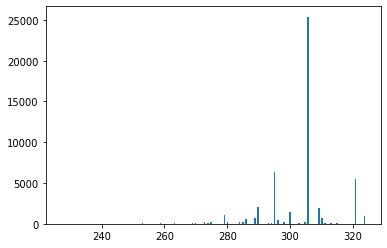

In [40]:
# Simulate it many times
bs = [ biden_sim() for _ in range(50000) ]
ts = [538-b for b in bs] # Trump electoral votes 
b_win = np.mean([b>=270 for b in bs])
print('Biden win probability is '+str(b_win))
import matplotlib.pyplot as plt
plt.hist(bs,bins=200)

t_win = np.mean([b<=268 for b in bs ])
tie = np.mean([b==269 for b in bs ])
print('Trump win probability is '+str(t_win))
print('Tie probability is '+ str(tie))
b270 = np.mean([b==270 for b in bs])
print('Biden=270 probability is '+str(b270))

In [41]:
# Compute inverse probabilities (European quoting convention) for range outcomes
prices = {'trump_270_299':1./np.mean([t>=270 and t<=299 for t in ts]),
          'trump_300_329':1./np.mean([t>=300 and t<=329 for t in ts]),
          'biden_270_299':1./np.mean([b>=270 and b<=299 for b in bs]),
          'biden_300_329':1./np.mean([b>=300 and b<=329 for b in bs]),
          'biden_330_359':1./np.mean([b>=330 and b<=359 for b in bs]),
          'biden_m_100.5':1./np.mean([b-t-100.5>0 for b,t in zip(bs,ts)]),
          'biden_m_48.5':1./np.mean([b-t-48.5>0 for b,t in zip(bs,ts)])}
pprint(prices)

{'biden_270_299': 3.837298541826554,
 'biden_300_329': 1.37211855104281,
 'biden_330_359': inf,
 'biden_m_100.5': 7.788161993769471,
 'biden_m_48.5': 1.1452392404773357,
 'trump_270_299': 136.6120218579235,
 'trump_300_329': 8333.333333333334}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [32]:
# American quoting conventions
def pm(p):
   if p>0.5:
     return '-'+str(round(100*(p/(1-p)),0))
   else:
     return '+'+str(round(100/p - 100,0))
examples = {'p=0.33333':pm(0.333333),
            'p=0.75':pm(0.75)}
#pprint(examples)

prices = {'trump_270_or_more':pm(t_win),
          'biden_270_or_more':pm(b_win),
          'trump_270_299':pm(np.mean([t>=270 and t<=299 for t in ts])),
          'trump_300_329':pm(np.mean([t>=300 and t<=329 for t in ts])),
          'biden_270_299':pm(np.mean([b>=270 and b<=299 for b in bs])),
          'biden_300_329':pm(np.mean([b>=300 and b<=329 for b in bs]))}
pprint(prices)

{'biden_270_299': '+290.0',
 'biden_270_or_more': '-4019.0',
 'biden_300_329': '-257.0',
 'trump_270_299': '+5407.0',
 'trump_270_or_more': '+5169.0',
 'trump_300_329': '+121851.0'}
